X_processed shape: (148517, 95)
y shape: (148517,)
Model loaded from: ../models\nslkdd_dnn_model.keras
Loaded model_columns from: ../models\columns.save
LIME explainer created.
Explaining instance index: 0
True label: 0 -> Normal
Predicted probabilities [Normal, Attack]: [0.8879127  0.11208729]
Predicted class: 0 -> Normal


,Feature,Contribution
0,flag_S1 <= -0.05,-0.681037
1,service_ntp_u <= -0.03,-0.641781
2,flag_S2 <= -0.03,-0.494066
3,service_red_i <= -0.01,-0.479303
4,service_X11 <= -0.02,-0.439669
5,service_domain_u <= -0.27,-0.264449
6,flag_SH <= -0.05,0.193718
7,service_nntp <= -0.05,0.168213
8,service_uucp <= -0.07,0.136483
9,service_rje <= -0.03,0.086020


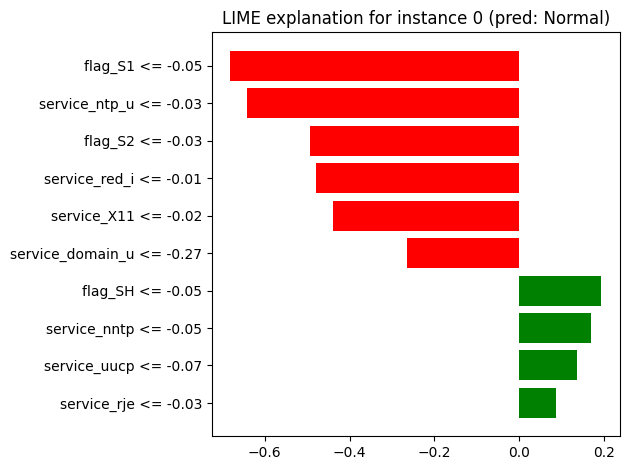

In [4]:
import numpy as np
import pandas as pd
import joblib
from lime.lime_tabular import LimeTabularExplainer
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------------
# 1) Paths (adapt if needed)
# ------------------------------------------------------------------
DATA_DIR = "../data"
MODELS_DIR = "../models"

X_PATH = os.path.join(DATA_DIR, "X.npy")          # preprocessed features (already scaled/encoded)
Y_PATH = os.path.join(DATA_DIR, "y.npy")          # labels
MODEL_PATH = os.path.join(MODELS_DIR, "nslkdd_dnn_model.keras")  # or .h5 if you still use it
COLUMNS_PATH = os.path.join(MODELS_DIR, "columns.save")     # if you saved feature names

# ------------------------------------------------------------------
# 2) Load data, model, and feature names
# ------------------------------------------------------------------
X_processed = np.load(X_PATH)
y = np.load(Y_PATH)

print("X_processed shape:", X_processed.shape)
print("y shape:", y.shape)

model = load_model(MODEL_PATH)
print("Model loaded from:", MODEL_PATH)

# Load feature names (model_columns) if you saved them during preprocessing
if os.path.exists(COLUMNS_PATH):
    model_columns = joblib.load(COLUMNS_PATH)
    print("Loaded model_columns from:", COLUMNS_PATH)
else:
    # Fallback: use a simple index-based list (less interpretable)
    model_columns = [f"feature_{i}" for i in range(X_processed.shape[1])]
    print("WARNING: model_columns.pkl not found; using generic feature names.")

feature_names = model_columns
class_names = ["Normal", "Attack"]

# Sanity check
if len(feature_names) != X_processed.shape[1]:
    print("WARNING: len(feature_names) != X_processed.shape[1]")
    print("feature_names:", len(feature_names), "  X_processed.shape[1]:", X_processed.shape[1])

# ------------------------------------------------------------------
# 3) Create LIME explainer
# ------------------------------------------------------------------
explainer = LimeTabularExplainer(
    training_data=X_processed,       # already scaled/encoded
    feature_names=feature_names,
    class_names=class_names,
    mode="classification"
)

print("LIME explainer created.")

# ------------------------------------------------------------------
# 4) Prediction function for LIME
# ------------------------------------------------------------------
def predict_fn(x):
    """
    LIME expects probabilities for all classes.
    Our model outputs P(Attack) as a single column.
    We convert it to [P(Normal), P(Attack)].
    """
    # x must be 2D: (n_samples, n_features)
    p_attack = model.predict(x, verbose=0).reshape(-1)   # shape: (n_samples,)
    # Clip to avoid exact 0/1 for numerical stability
    p_attack = np.clip(p_attack, 1e-6, 1 - 1e-6)
    p_normal = 1.0 - p_attack

    return np.vstack([p_normal, p_attack]).T  # shape: (n_samples, 2)

# ------------------------------------------------------------------
# 5) Choose an instance to explain
# ------------------------------------------------------------------
np.random.seed(42)
idx = 0  # you can set a specific index, or use np.random.randint(0, X_processed.shape[0])

data_row = X_processed[idx]
true_label = int(y[idx])

print(f"Explaining instance index: {idx}")
print("True label:", true_label, "->", class_names[true_label])

proba = predict_fn(data_row.reshape(1, -1))[0]
pred_class = np.argmax(proba)
print("Predicted probabilities [Normal, Attack]:", proba)
print("Predicted class:", pred_class, "->", class_names[pred_class])

# ------------------------------------------------------------------
# 6) Generate LIME explanation
# ------------------------------------------------------------------
explanation = explainer.explain_instance(
    data_row,
    predict_fn,
    num_features=10,   # top features to show
    labels=[pred_class]
)

# ------------------------------------------------------------------
# 7) Display top features as DataFrame
# ------------------------------------------------------------------
lime_list = explanation.as_list(label=pred_class)
lime_df = pd.DataFrame(lime_list, columns=["Feature", "Contribution"])
display(lime_df)

# ------------------------------------------------------------------
# 8) Plot explanation
# ------------------------------------------------------------------
fig = explanation.as_pyplot_figure(label=pred_class)
plt.title(f"LIME explanation for instance {idx} (pred: {class_names[pred_class]})")
plt.tight_layout()
plt.show()